# Install & Import Library

In [1]:
!pip install kagglehub -q

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse

# Load Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("rmisra/clothing-fit-dataset-for-size-recommendation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/clothing-fit-dataset-for-size-recommendation


In [4]:
json_path = os.path.join(path, "renttherunway_final_data.json")
df = pd.read_json(json_path, lines=True)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


# Data Preprocessing

kita menyimpan dataset asli terlebih dahulu

In [5]:
df_ori = df.copy()

karena tidak membutuhkan `review_summary` dan `review_text` dari tujuan kita, maka akan dibuang saja

In [6]:
df.drop(columns=['review_summary', 'review_text'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fit          192544 non-null  object 
 1   user_id      192544 non-null  int64  
 2   bust size    174133 non-null  object 
 3   item_id      192544 non-null  int64  
 4   weight       162562 non-null  object 
 5   rating       192462 non-null  float64
 6   rented for   192534 non-null  object 
 7   body type    177907 non-null  object 
 8   category     192544 non-null  object 
 9   height       191867 non-null  object 
 10  size         192544 non-null  int64  
 11  age          191584 non-null  float64
 12  review_date  192544 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 19.1+ MB


In [8]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date']

,review_date
0,2016-04-20
1,2013-06-18
2,2015-12-14
3,2014-02-12
4,2016-09-26
...,...
192539,2016-05-18
192540,2016-09-30
192541,2016-03-04
192542,2015-11-25


In [9]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,hourglass,romper,"5' 8""",14,28.0,2016-04-20
1,fit,273551,34b,153475,132lbs,10.0,other,straight & narrow,gown,"5' 6""",12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0,2015-12-14
3,fit,909926,34c,126335,135lbs,8.0,formal affair,pear,dress,"5' 5""",8,34.0,2014-02-12
4,fit,151944,34b,616682,145lbs,10.0,wedding,athletic,gown,"5' 9""",12,27.0,2016-09-26


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   fit          192544 non-null  object        
 1   user_id      192544 non-null  int64         
 2   bust size    174133 non-null  object        
 3   item_id      192544 non-null  int64         
 4   weight       162562 non-null  object        
 5   rating       192462 non-null  float64       
 6   rented for   192534 non-null  object        
 7   body type    177907 non-null  object        
 8   category     192544 non-null  object        
 9   height       191867 non-null  object        
 10  size         192544 non-null  int64         
 11  age          191584 non-null  float64       
 12  review_date  192544 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 19.1+ MB


In [11]:
df['bust size'].unique()

array(['34d', '34b', nan, '34c', '32b', '34d+', '36d', '36a', '32d+',
       '36c', '32c', '32dd', '30dd', '32d', '36b', '34a', '34dd',
       '40ddd/e', '32a', '38d+', '38c', '34ddd/e', '38a', '38b', '38d',
       '36ddd/e', '38dd', '38f', '42dd', '36dd', '40g', '40dd', '28f',
       '30ddd/e', '32ddd/e', '28b', '36d+', '40d', '28dd', '34f', '42c',
       '30d', '30b', '42d', '34aa', '32aa', '36f', '28c', '40b', '36aa',
       '34g', '32f', '42ddd/e', '40c', '28g', '28aa', '36g', '30a',
       '44ddd/e', '30c', '30aa', '44dd', '32i', '32g', '30g', '38h',
       '30h', '34j', '38ddd/e', '32h', '28a', '44d', '40h', '38g', '34h',
       '36j', '40f', '36h', '28ddd/e', '44f', '34i', '30f', '36i', '30i',
       '28h', '42b', '42j', '32j', '46c', '48d', '38aa', '38i', '48dd',
       '28d', '28i', '46ddd/e', '42g', '44c', '42f', '40j', '38j', '46f',
       '44b', '44g', '42h', '40i', '44h'], dtype=object)

In [12]:
df['rating'].unique()

array([10.,  8.,  4.,  6.,  2., nan])

In [13]:
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan, 'party: cocktail'], dtype=object)

In [14]:
df['body type'].unique()

array(['hourglass', 'straight & narrow', nan, 'pear', 'athletic',
       'full bust', 'petite', 'apple'], dtype=object)

In [15]:
df['category'].unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirt', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'turtleneck', 'trousers',
       'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight', 'kimono',
       'for', 'crewneck', 'skirts', 'parka', 'buttondown', 'skort',
       'sweatershirt', 'sweatpants', 'jeans'], dtype=object)

In [16]:
print(df.isna().sum(), f", Jumlah baris: {len(df)}, Jumlah missing values: {df.isna().sum().sum()}")

fit                0
user_id            0
bust size      18411
item_id            0
weight         29982
rating            82
rented for        10
body type      14637
category           0
height           677
size               0
age              960
review_date        0
dtype: int64 , Jumlah baris: 192544, Jumlah missing values: 64759


# Data Preparation

karena fitur `rating` dan `rented for` memiliki sedikit missing value, maka akan di drop saja

In [17]:
df = df.dropna(subset=['rating', 'rented for'])

untuk mengisi nilai kosong `bust size` dan `body type`, menggunakan modus karena type data object

In [18]:
# Imputasi kolom kategori dengan modus
df['bust size'] = df['bust size'].fillna(df['bust size'].mode()[0])
df['body type'] = df['body type'].fillna(df['body type'].mode()[0])

untuk melakukan imputasi kolom `weight`, akan melihat distribusi datanya sebagai berikut

In [19]:
df['weight'] = df['weight'].str.replace('lbs', '', regex=False).astype(float)

In [20]:
df['weight'].skew()

np.float64(1.39555123013035)

karena sangat skewness (1.39555123013035 > 1), maka akan menggunakan median untuk imputasi kolom `weight` dan diubah ke satuan standar internasional (kg)

In [21]:
df['weight'] = df['weight'].fillna(df['weight'].median()).apply(lambda x: x * 0.453592)

lakukan hal yang sama untuk `height` dan `age` dengan cek distribusi dahulu. `height` diubah dari feet'inchi" menjadi satuan inchi

In [22]:
df['height'] = df['height'].apply(lambda x: int(x.split("'")[0]) * 12 + int(x.split('"')[0].split()[-1]) if pd.notnull(x) else np.nan)

In [23]:
print(f"{df['height'].skew(), df['age'].skew()}")

(np.float64(0.13822170719981394), np.float64(1.5021567728417835))


karena `height`~ 0, digunakan mean untuk imputasi dan diubah satuan dari inchi ke satuan standar internasional (cm). sedangkan `age` menggunakan median karena nilai skewed > 1, menandakan data terdistribusi miring

In [24]:
df['height'] = df['height'].fillna(df['height'].mean()).apply(lambda x: x * 2.54)
df['age'] = df['age'].fillna(df['age'].median())

kemudian untuk memastikan, akan dicek lagi missing values sebagai berikut

In [25]:
df.isna().sum()

,0
fit,0
user_id,0
bust size,0
item_id,0
weight,0
rating,0
rented for,0
body type,0
category,0
height,0


In [26]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,review_date
0,fit,420272,34d,2260466,62.142104,10.0,vacation,hourglass,romper,172.72,14,28.0,2016-04-20
1,fit,273551,34b,153475,59.874144,10.0,other,straight & narrow,gown,167.64,12,36.0,2013-06-18
2,fit,360448,34b,1063761,61.234920,10.0,party,hourglass,sheath,162.56,4,116.0,2015-12-14
3,fit,909926,34c,126335,61.234920,8.0,formal affair,pear,dress,165.10,8,34.0,2014-02-12
4,fit,151944,34b,616682,65.770840,10.0,wedding,athletic,gown,175.26,12,27.0,2016-09-26


data hampir dirapihkan, sekarang dilakukan perapihan data lagi pada kolom `bust size`, `weight` dan `review date`

disini akan membatasi dua digit belakang koma untuk `weight`

In [27]:
df['weight'] = df['weight'].round(2)

In [28]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,review_date
0,fit,420272,34d,2260466,62.14,10.0,vacation,hourglass,romper,172.72,14,28.0,2016-04-20
1,fit,273551,34b,153475,59.87,10.0,other,straight & narrow,gown,167.64,12,36.0,2013-06-18
2,fit,360448,34b,1063761,61.23,10.0,party,hourglass,sheath,162.56,4,116.0,2015-12-14
3,fit,909926,34c,126335,61.23,8.0,formal affair,pear,dress,165.10,8,34.0,2014-02-12
4,fit,151944,34b,616682,65.77,10.0,wedding,athletic,gown,175.26,12,27.0,2016-09-26


sekarang kita ingin mendalami fitur `bust size`, dikarenakan memiliki banyak jenis satuan. `bust size`(Lingkar dada) kita pecah jadi dua kolom, yaitu `band_size` (Lingkar dada (di bawah payudara, sekitar tulang rusuk)) dan `cup_size_raw` (Selisih antara lingkar payudara dan lingkar dada) dimana `band_size` menyimpan angkanya dan `cup_size_raw` menyimpan kode hurufnya yang bersifat kategorikal ordinal

In [29]:
def parse_bust_size(size):
    if pd.isnull(size):
        return np.nan, np.nan
    match = re.match(r"(\d+)([a-zA-Z/+]+)", size)
    if match:
        band = int(match.group(1))
        cup = match.group(2).lower().replace('+', '').replace('/', '')
        return band, cup
    return np.nan, np.nan

df[['band_size', 'cup_size_raw']] = df['bust size'].apply(lambda x: pd.Series(parse_bust_size(x)))

In [30]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,review_date,band_size,cup_size_raw
0,fit,420272,34d,2260466,62.14,10.0,vacation,hourglass,romper,172.72,14,28.0,2016-04-20,34,d
1,fit,273551,34b,153475,59.87,10.0,other,straight & narrow,gown,167.64,12,36.0,2013-06-18,34,b
2,fit,360448,34b,1063761,61.23,10.0,party,hourglass,sheath,162.56,4,116.0,2015-12-14,34,b
3,fit,909926,34c,126335,61.23,8.0,formal affair,pear,dress,165.10,8,34.0,2014-02-12,34,c
4,fit,151944,34b,616682,65.77,10.0,wedding,athletic,gown,175.26,12,27.0,2016-09-26,34,b


kemudian kita ingin `review date` dijadikan `season`, karena kita ingin tahu kapan pengguna menyewa tersebut sehingga memberikan rating yang sedemikian tersebut

In [31]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Buat kolom baru 'season'
df['season'] = df['review_date'].apply(get_season)

In [32]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,review_date,band_size,cup_size_raw,season
0,fit,420272,34d,2260466,62.14,10.0,vacation,hourglass,romper,172.72,14,28.0,2016-04-20,34,d,Spring
1,fit,273551,34b,153475,59.87,10.0,other,straight & narrow,gown,167.64,12,36.0,2013-06-18,34,b,Summer
2,fit,360448,34b,1063761,61.23,10.0,party,hourglass,sheath,162.56,4,116.0,2015-12-14,34,b,Winter
3,fit,909926,34c,126335,61.23,8.0,formal affair,pear,dress,165.10,8,34.0,2014-02-12,34,c,Winter
4,fit,151944,34b,616682,65.77,10.0,wedding,athletic,gown,175.26,12,27.0,2016-09-26,34,b,Fall


sekarang kita membuang kolom `bust size` dan `review_date` karena udah di representasikan dalam bentuk lain

In [33]:
df.drop(columns=['bust size', 'review_date'], inplace=True)

In [34]:
df.head()

,fit,user_id,item_id,weight,rating,rented for,body type,category,height,size,age,band_size,cup_size_raw,season
0,fit,420272,2260466,62.14,10.0,vacation,hourglass,romper,172.72,14,28.0,34,d,Spring
1,fit,273551,153475,59.87,10.0,other,straight & narrow,gown,167.64,12,36.0,34,b,Summer
2,fit,360448,1063761,61.23,10.0,party,hourglass,sheath,162.56,4,116.0,34,b,Winter
3,fit,909926,126335,61.23,8.0,formal affair,pear,dress,165.10,8,34.0,34,c,Winter
4,fit,151944,616682,65.77,10.0,wedding,athletic,gown,175.26,12,27.0,34,b,Fall


untuk memastikan, cek ulang missing value apakah ada atau tidak

In [35]:
df.isna().sum()

,0
fit,0
user_id,0
item_id,0
weight,0
rating,0
rented for,0
body type,0
category,0
height,0
size,0


lalu kita akan cek karakteristik label dari `cup_size_raw`

In [36]:
df['cup_size_raw'].unique()

array(['d', 'b', 'c', 'a', 'dd', 'ddde', 'f', 'g', 'aa', 'i', 'h', 'j'],
      dtype=object)

kita lihat terdapat `ddde` pada jenis label. ini berasal dari fitur sebelumnya yang pake `ddd/e` seperti 34ddd/e (bisa diliat jenis label di bagian `bust size` di data preparation). dalam hal ini, `ddde` akan diganti dengan `e`

In [37]:
df['cup_size_raw'] = df['cup_size_raw'].replace('ddde', 'e')

sekarang akan kita ingin melihat lagi jenis label `rented for`

In [38]:
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', 'party: cocktail'], dtype=object)

In [39]:
df[df['rented for'] == 'party: cocktail']

,fit,user_id,item_id,weight,rating,rented for,body type,category,height,size,age,band_size,cup_size_raw,season
100942,fit,289468,174258,51.71,8.0,party: cocktail,petite,dress,157.48,12,35.0,34,b,Fall


`party: cocktail` akan digabungkan ke `party` untuk bentuk perumuman

In [40]:
df['rented for'] = df['rented for'].replace({'party: cocktail': 'party'})

sekarang akan kita ingin melihat lagi jenis label `categorical` (masih sama bentuknya di bagian data preparation)

In [41]:
df['category'].unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirt', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'turtleneck', 'trousers',
       'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight', 'kimono',
       'for', 'crewneck', 'skirts', 'parka', 'buttondown', 'skort',
       'sweatershirt', 'sweatpants', 'jeans'], dtype=object)

ada banyak duplikasi dalam bentuk jamak dan tunggal, kita akan konsilidasi dalam satu bentuk pada proses berikut

In [42]:
consolidation_map = {
    'pant': 'pants',
    'legging': 'leggings',
    'trouser': 'trousers',
    'culotte': 'culottes',
    'skirt': 'skirts'
}

df['category'] = df['category'].replace(consolidation_map)

dan ada dalam bentuk typo dan sinonim teks, kita akan perbaiki dalam satu bentuk pada proses berikut

In [43]:
alternate_mapping = {
    'sweatshirt': 'sweatershirt',
    'tight': 'tights',
    'kaftan': 'caftan',
    'tee' : 't-shirt'
}

df['category'] = df['category'].replace(alternate_mapping)

lalu kita cek lagi

In [44]:
df['category'].unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirts', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trousers', 'midi', 'print', 'knit', 'sweatershirt', 'peacoat',
       'caftan', 'overalls', 'jogger', 't-shirt', 'combo', 'henley',
       'cami', 'blouson', 'turtleneck', 'overcoat', 'hoodie', 'tights',
       'kimono', 'for', 'crewneck', 'parka', 'buttondown', 'skort',
       'sweatpants', 'jeans'], dtype=object)

kita melihat ada barang yang tidak relevan, misalnya print dan for

In [45]:
df[df['category'] == 'for']

,fit,user_id,item_id,weight,rating,rented for,body type,category,height,size,age,band_size,cup_size_raw,season
36852,small,602302,2270513,67.59,10.0,everyday,hourglass,for,167.64,20,37.0,34,c,Winter
70615,small,504320,2270513,61.23,8.0,everyday,hourglass,for,170.18,20,39.0,34,b,Fall
101357,fit,762065,2270513,58.97,10.0,everyday,athletic,for,162.56,8,34.0,34,a,Fall
101890,fit,175028,2270513,58.97,10.0,everyday,straight & narrow,for,175.26,4,39.0,34,c,Fall
110530,fit,306218,2270513,63.50,10.0,everyday,athletic,for,175.26,8,28.0,34,b,Fall
117580,fit,616450,2270513,61.23,10.0,everyday,hourglass,for,162.56,4,26.0,34,b,Fall
131261,fit,758006,2270513,72.57,10.0,everyday,hourglass,for,172.72,14,39.0,36,d,Winter


`category: for` terlihat hanya untuk barang dengan `item_id` = 2270513, kita akan analisis `review_text` dari dataset aslinya

In [46]:
# Tampilkan seluruh isi string di kolom
pd.set_option('display.max_colwidth', None)
df_ori[df_ori['item_id'] == 2270513]['review_text']

,review_text
36852,"I ordered a large. I don't know that it runs small or if it is supposed to be form fitting. I would rather wear something looser, so I think the large was perfect for me. I plan on looking for this to buy. I get compliments when I wear it out. I love it! I love the layered look and I love that it is long enough to cover my back when I sit."
70615,"There really wasn't anything wrong with it, it just wasn't my style. I'm typically a size M and I got the L and it fit. I didn't realize the turtleneck was a ribbed material, I thought it was more of a finer gauge. Again, nothing really wrong with it, just not special."
101357,cute
101890,I love this top. The fabric is so soft and was easy to layer with a leather jacket. Love the thumb holes in the sleeves. Perfect for the transition into fall and winter.
110530,"Fit great, the sleeves are very long and the thumb holes are a cut touch. Great Fall turtleneck however it is Lightweight."
117580,"This top is so simple and casual, but I love it!! its super stretchy, soft, and comfortable. Run your errands and hang with friends comfortably with this top on. I also love the thumb hole in the sleeve. This is a must have!"
131261,"This is a comfy shirt, great length. Wore it on the weekend to a child's birthday party. Cuter in person."


In [47]:
pd.reset_option('display.max_colwidth')

terlihat ini kategori sebagai 'turtleneck' untuk for ini, sekarang kita analisis 'print' lanjutannya

In [48]:
df[df['category'] == 'print']

,fit,user_id,item_id,weight,rating,rented for,body type,category,height,size,age,band_size,cup_size_raw,season
2885,fit,470461,545632,57.61,10.0,party,hourglass,print,175.26,8,43.0,34,c,Summer
4977,fit,532788,545632,58.97,8.0,other,straight & narrow,print,175.26,8,32.0,34,a,Summer
5412,fit,112850,545632,52.16,10.0,wedding,petite,print,157.48,8,30.0,34,b,Summer
8740,fit,511128,545632,72.57,10.0,everyday,full bust,print,167.64,14,33.0,38,d,Fall
9427,fit,662665,545632,44.91,10.0,other,petite,print,154.94,4,48.0,32,c,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180960,fit,925642,545632,82.55,10.0,other,hourglass,print,170.18,20,52.0,38,c,Spring
181400,fit,85626,545632,61.23,8.0,party,hourglass,print,162.56,14,28.0,34,d,Spring
182916,small,741951,545632,79.38,6.0,party,hourglass,print,170.18,20,38.0,36,c,Winter
184550,fit,848901,545632,74.84,10.0,party,hourglass,print,172.72,14,37.0,38,d,Spring


hal yang sama terjadi untuk `category: print`, hanya terlihat untuk `item_id: 545632` kita akan melihat `review_text` barang tersebut dari dataset aslinya

In [49]:
pd.set_option('display.max_colwidth', None)
df_ori[df_ori['item_id'] == 545632]['review_text'].head()

,review_text
2885,"The dress fits true to size , tends to run up a little when waking but no big deal"
4977,"I typically wear a 2 or 4 in any type of dress; fitted otherwise. The small fit quite comfortably and, despite my height, was an appropriate length for a country club bridal shower. The material is high quality but still stretches; incredibly comfortable. The cut of the sleeve is not forgiving if you have any upper-arm concerns. But the print is flattering and paired well with black peep-toes."
5412,"I tried both the XS and S, and ended up wearing the small because it didn't ride up as much as the smaller size. The for and print were amazing and I wish I owned this dress. The scuba fabric was thick without being hot, and it was nice to be able to wear a normal bra. I received a ton of compliments!"
8740,"I have loved every dress I have tried from this brand. I usually am a Herve woman. I have a hourglass shape and for years I could not find items I could wear straight from the rack. Every one of these dresses fits like a dream, this was no exception. I get a medium for a sexier look and go large for a daytime look, wither fit, the large is juts a bit less form fitting. I am a natural 36 H 28 45 (about)"
9427,Body hugging. Mid thigh. Gorgeous intricate pattern design perfect for spring and summer events. Very comfortable to wear. Daytime and evening appropriate.


In [50]:
pd.reset_option('display.max_colwidth')

terlihat secara eksplisit ini kategori serupa dress untuk print. selanjutnya kita akan ubah dalam satu bentuk sebagai berikut

In [51]:
anomali_mapping = {
    'for': 'turtleneck',
    'print': 'dress'
}

df['category'] = df['category'].replace(anomali_mapping)

sekarang `category` sudah aman dengan jenis label sebagai berikut

In [52]:
df['category'].unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirts', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trousers', 'midi', 'knit', 'sweatershirt', 'peacoat', 'caftan',
       'overalls', 'jogger', 't-shirt', 'combo', 'henley', 'cami',
       'blouson', 'turtleneck', 'overcoat', 'hoodie', 'tights', 'kimono',
       'crewneck', 'parka', 'buttondown', 'skort', 'sweatpants', 'jeans'],
      dtype=object)

karena tidak ada kejanggalan pada data ketegorical yang lain, kemudian akan di cek apakah ada data yang terduplikat

In [53]:
df.duplicated().sum()

np.int64(229)

kita akan menghapus data duplikat

In [54]:
df = df.drop_duplicates().copy()

In [55]:
df.duplicated().sum()

np.int64(0)

kita gabungkan data kategorical jadi satu

In [56]:
df['text_features'] = (
    df['category'].astype(str) + ' ' +
    df['rented for'].astype(str) + ' ' +
    df['season'].astype(str) + ' ' +
    df['body type'].astype(str) + ' ' +
    df['cup_size_raw'].astype(str)
)

kita akan melakukan vektorisasi dengan tf-idf untuk data kategorikal

In [57]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['text_features'])  # Bentuk: (n_samples, n_tfidf_features)

sekarang lakukan normalisasi untuk data numerik

In [58]:
numerical_features = ['weight', 'height', 'size', 'age', 'band_size']

scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_features])  # Bentuk: (n_samples, n_numerical_features)

sekarang kita gabungkan keduanya

In [59]:
# Konversi scaled_numerical ke bentuk sparse agar bisa digabung
numerical_sparse = scipy.sparse.csr_matrix(scaled_numerical)

# Gabungkan fitur akhir
item_vectors = scipy.sparse.hstack([tfidf_matrix, numerical_sparse])  # Shape: (n_items, total_features)

dataset telah siap digunakan untuk tahap selanjutnya.

# Model Development dengan Content Based Filtering

Tujuan :
1. Merekomendasikan pakaian baru yang cocok untuk pengguna berdasarkan histori pakaian yang telah mereka merasa pas ("fit").
2. Merekomendasikan pakaian baru yang cocok untuk pengguna berdasarkan histori pakaian yang telah mereka merasa pas ("fit") di musim saat direkomendasikan.

Buat Profil User dari Item yang "fit"

In [60]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

user_id = 151944

# Ambil item user yang 'fit'
user_items = df[(df['user_id'] == user_id) & (df['fit'] == 'fit')]
user_indices = user_items.index

if len(user_indices) == 0:
    print(f"❗ User {user_id} belum memiliki item dengan 'fit'. Tidak bisa membuat user profile.")
    user_profile_vector = None
else:
    user_profile_vector = np.asarray(item_vectors[user_indices].mean(axis=0)).reshape(1, -1)

Hitung Similarity dan Rekomendasi

In [61]:
if user_profile_vector is not None:
    # Hitung cosine similarity user profile vs semua item
    similarity_scores = cosine_similarity(user_profile_vector, item_vectors).flatten()

    # Copy df supaya tidak overwrite
    df_copy = df.copy()
    df_copy['similarity'] = similarity_scores

    # Filter item yang sudah dilihat user
    seen_item_ids = df_copy[df_copy['user_id'] == user_id]['item_id'].unique()
    candidate_df = df_copy[~df_copy['item_id'].isin(seen_item_ids)].copy()

    # Ambil top-N rekomendasi
    top_n = 5
    recommendations = candidate_df.sort_values(by='similarity', ascending=False).head(top_n)

    print(f"Rekomendasi untuk user {user_id}:")
    print(recommendations[['item_id', 'similarity', 'category']])
else:
    recommendations = None

Rekomendasi untuk user 151944:
        item_id  similarity category
115527  1531631    0.856196     gown
151289   162634    0.852565     gown
178620  1487216    0.851125     gown
92083    432275    0.848164     gown
108378   131533    0.845836     gown


sekarang telah dibikin sistem rekomendasi, sebagai contoh `user_id = 151944` direkomendasikan `item_id = [1531631, 162634, 1487216, 432275, 131533]`

In [62]:
seasons = df['season'].unique()

for season in seasons:
    print(f"\n📅 Rekomendasi untuk musim: {season}")

    seasonal_candidates = candidate_df[candidate_df['season'] == season]

    if len(seasonal_candidates) == 0:
        print("Tidak ada kandidat item untuk musim ini.")
        continue

    seasonal_top = seasonal_candidates.sort_values(by='similarity', ascending=False).head(top_n)

    print(seasonal_top[['item_id', 'similarity', 'category', 'season']])


📅 Rekomendasi untuk musim: Spring
        item_id  similarity category  season
115527  1531631    0.856196     gown  Spring
151289   162634    0.852565     gown  Spring
178620  1487216    0.851125     gown  Spring
92083    432275    0.848164     gown  Spring
108378   131533    0.845836     gown  Spring

📅 Rekomendasi untuk musim: Summer
        item_id  similarity category  season
46057    131117    0.775542     gown  Summer
57305    862446    0.769009     gown  Summer
87115    139792    0.765187     gown  Summer
99835    166006    0.760813     gown  Summer
139613  1845435    0.757553     gown  Summer

📅 Rekomendasi untuk musim: Winter
        item_id  similarity category  season
53890    503972    0.781975     gown  Winter
176111   943243    0.777405     gown  Winter
141342  1032121    0.771062     gown  Winter
29111    985499    0.770304     gown  Winter
56172   1729232    0.766560     gown  Winter

📅 Rekomendasi untuk musim: Fall
        item_id  similarity category season
19734   

selain itu, juga bisa ditampilkan rekomendasi `item_id` sesuai musim. tinggal diintegrasikan musimnya dengan tanggal kejadian saat itu di interface pengguna

## Evaluation

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ambil rating asli user
rated_items = df.dropna(subset=['rating'])
rated_df = df_copy[(df_copy['item_id'].isin(rated_items['item_id'])) & (df_copy['user_id'] == user_id)].copy()

if rated_df.empty:
    print("⚠️ User belum punya rating untuk evaluasi.")
else:
    y_pred = rated_df['similarity'].values
    y_true = rated_df['rating'].values

    # Normalisasi similarity ke 2, 4, 6, 8, 10
    valid_ratings = np.array([2.0, 4.0, 6.0, 8.0, 10.0])

    if y_pred.max() == y_pred.min():
        y_pred_norm = np.full_like(y_pred, 6)
    else:
        y_pred_scaled = 1 + (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()) * 9
        y_pred_norm = np.array([valid_ratings[np.abs(valid_ratings - val).argmin()] for val in y_pred_scaled])

    rmse = np.sqrt(mean_squared_error(y_true, y_pred_norm))
    mae = mean_absolute_error(y_true, y_pred_norm)

    print("\n📈 Evaluasi Prediktif (Normalized to 1–10):")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")


📈 Evaluasi Prediktif (Normalized to 1–10):
RMSE: 4.5981
MAE : 3.7143


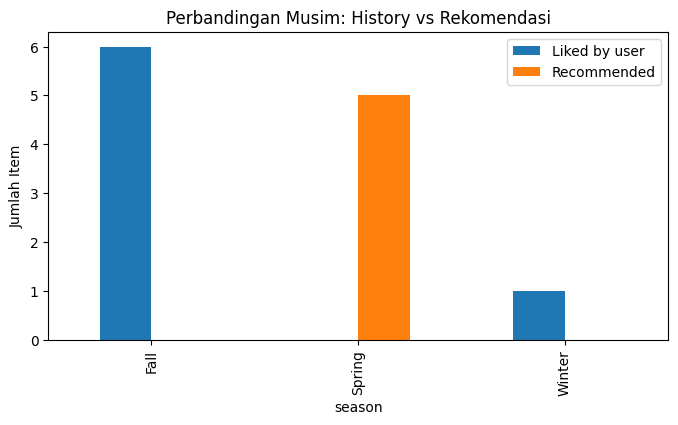

In [64]:
# Lihat distribusi musim dari item yang disukai user
liked_seasons = df[(df['user_id'] == user_id) & (df['fit'] == 'fit')]['season'].value_counts()

# Bandingkan dengan musim dari rekomendasi teratas
recommended_seasons = recommendations['season'].value_counts()

# Gabungkan untuk perbandingan
season_compare = pd.DataFrame({
    'Liked by user': liked_seasons,
    'Recommended': recommended_seasons
}).fillna(0)

season_compare.plot(kind='bar', figsize=(8,4), title='Perbandingan Musim: History vs Rekomendasi')
plt.ylabel('Jumlah Item')
plt.show()

item yang disukai user hanya ada di fall dan summer, dan rekomendasi sistem malah dominan di spring, kita akan tambahkan Preferensi Musim ke rekomendasi

In [65]:
# Hitung preferensi musim user (dari item 'fit')
liked_seasons = df[(df['user_id'] == user_id) & (df['fit'] == 'fit')]['season'].value_counts(normalize=True)

# Gabungkan ke candidate_df
candidate_df['season_pref'] = candidate_df['season'].map(liked_seasons).fillna(0)

# Gabungkan dengan similarity
alpha = 0.6  # bobot similarity
beta = 0.2   # bobot musim

candidate_df['hybrid_score'] = alpha * candidate_df['similarity'] + beta * candidate_df['season_pref']

# Ambil rekomendasi baru
recommendations = candidate_df.sort_values(by='hybrid_score', ascending=False).head(top_n)
print(recommendations[['item_id', 'similarity', 'category']])

        item_id  similarity category
19734    132738    0.826096     gown
178731  1986986    0.823996     gown
121599   987536    0.821249     gown
41142    898283    0.819549     gown
25484    153475    0.819255     gown


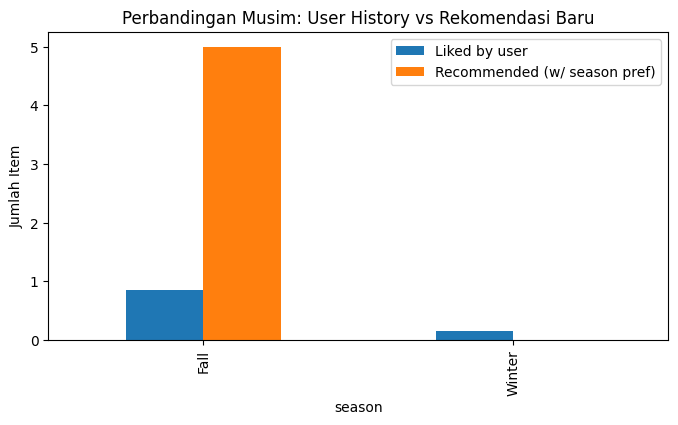

In [66]:
recommended_seasons = recommendations['season'].value_counts()

season_compare = pd.DataFrame({
    'Liked by user': liked_seasons,
    'Recommended (w/ season pref)': recommended_seasons
}).fillna(0)

season_compare.plot(kind='bar', figsize=(8,4), title='Perbandingan Musim: User History vs Rekomendasi Baru')
plt.ylabel('Jumlah Item')
plt.show()

kemudian hitung ulang metrik evaluasi

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ambil item yang pernah dirating user
rated_items = df.dropna(subset=['rating'])
rated_df = df_copy[(df_copy['item_id'].isin(rated_items['item_id'])) & (df_copy['user_id'] == user_id)].copy()

if rated_df.empty:
    print("⚠️ User belum punya rating untuk evaluasi.")
else:
    # Hitung preferensi musim user
    liked_seasons = df[(df['user_id'] == user_id) & (df['fit'] == 'fit')]['season'].value_counts(normalize=True)
    rated_df['season_pref'] = rated_df['season'].map(liked_seasons).fillna(0)

    # Hitung hybrid_score untuk rated_df
    alpha = 0.6
    beta = 0.2
    rated_df['hybrid_score'] = alpha * rated_df['similarity'] + beta * rated_df['season_pref']

    # Ground truth & prediction
    y_true = rated_df['rating'].values
    y_pred_raw = rated_df['hybrid_score'].values

    # Normalisasi ke range 2,4,6,8,10
    valid_ratings = np.array([2.0, 4.0, 6.0, 8.0, 10.0])

    if y_pred_raw.max() == y_pred_raw.min():
        y_pred_norm = np.full_like(y_pred_raw, 6)
    else:
        y_pred_scaled = 1 + (y_pred_raw - y_pred_raw.min()) / (y_pred_raw.max() - y_pred_raw.min()) * 9
        y_pred_norm = np.array([valid_ratings[np.abs(valid_ratings - val).argmin()] for val in y_pred_scaled])

    # Hitung metrik
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_norm))
    mae = mean_absolute_error(y_true, y_pred_norm)

    print("\n📈 Evaluasi Hybrid Score (Normalized to 1–10):")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")


📈 Evaluasi Hybrid Score (Normalized to 1–10):
RMSE: 4.2762
MAE : 3.4286
